# Longevity phenotypes in mice of various ages

In this notebook we consider a [study](https://www.nature.com/articles/s41467-022-34515-y) of phenotypic change in relation to aging in mice by Xie et al.  This is a large and complex study and we will only consider a few aspects of the study here.  Our focus in this notebook is on the study design and analysis plan, which includes many of the issues covered [here](https://github.com/kshedden/workshops/blob/main/dair3/design/design.md).

To keep this discussion accessible we will not be using advanced statistical methods, although there is plenty of opportunity to do so.  Also, we will not be discussing many implementation details of the code provided below, since our focus is on concepts related to rigorous study design and analysis.

## Data

The study data are available [here](https://data.mendeley.com/preview/ypz9zyc9rp?a=09b16f74-4581-48f7-94af-469e01757949), but you do not need to download the data directly from this link, as the script below will read a prepared version of the data from [Github](https://github.com/kshedden/workshops/tree/main/dair3/design/mouse_data).  If you are curious about how the data were prepared, see the [pool.py](https://github.com/kshedden/workshops/blob/main/dair3/design/mouse_data/pool.py) script, but you do not need to do this to work with the code in this notebook.

## Study design

Although this study considers change over the mouse lifespan, it is implemented as a [cross sectional](https://en.wikipedia.org/wiki/Cross-sectional_study) rather than a [longitudinal](https://en.wikipedia.org/wiki/Longitudinal_study) study.  The authors collected data at 6 distinct ages during the mouse lifespan (from 3-26 months), with around 15 independent mice assessed at each age. Mice observed at different ages are mutually independent.  

All mice in this study are male.  Current NIH guidance strongly advocates for sex balanced designs (this study was conducted in Europe).

A large number of phenotypes are measured.  Some, such as heart rate, can be measured on a living mouse, while others such as organ weights can only be made upon sacrifice of the animal (this is why the design is cross sectional).  Some components of the study involved an intervention, such as mutation of a gene or dietary modifications.  Many components of the study are observational, and consider changes in a phenotype such as heart rate in unperturbed mice of various ages.

The authors make a number of comments about their study design choices in the Discussion section of their paper.

## Scientific aims

This is an open-ended exploratory study that does not test a specific pre-specified hypothesis.  The researchers collected a large number of phenotypes and assessed them all in an "unbiased" manner for changes over the mouse lifespan.

This study has an [observational](https://en.wikipedia.org/wiki/Observational_study) component in which changes in some phenotypes occur naturalistically over the mouse lifespan.  It also includes an interventional component with three independent interventions: two genetic manipulations and a dietary intervention (intermittent fasting).  

The authors used both univariate and multivariate methods in ther study.  In univariate analyses, a single phenotype was considered in relation to age, and (if present) intervention group assignment.  Below, we aim to replicate a subset of the univariate analyses (both observational and interventional).  We do not further consider the multivariate analyses here, since these require more advanced statistical background.

In [1]:
import pandas as pd
import json
import urllib.request
import gzip
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import string
from scipy.stats import distributions

The next cell loads the data from a Github repository.  The data take the form of a dictionary that associates the figures of the paper with various data tables.

Each data table has two or three columns, giving the age and the recorded value for one phenotype, along with the intervention group assignment if an intervention was performed.

In [2]:
loc = "https://github.com/kshedden/workshops/raw/main/dair3/design/mouse_aging/mouse_data.json.gz"
with urllib.request.urlopen(loc) as url:
    fi = gzip.GzipFile(fileobj=url)
    md = json.load(fi)

We can count the number of datasets present in each section of the paper.

In [3]:
{k: len(md[k]) for k in md.keys()}

{'Figure2_phenotypes': 186,
 'Figure4_phenotypes': 202,
 'Figure5_phenotypes': 157,
 'Figure2_molecularMarkers': 167,
 'Figure3_phenotypes': 206}

The study data are stored as a large collection of small datasets.  The function below extracts one dataset and does some basic preprocessing of it.

In [4]:
def get_data(dset, vname, convert_age=True, standardize_vname=False):
  """
  Extract the data for phenotype 'vname' from data collection 'dset'.  If
  'convert_age' is True, the age is converted to numeric values.  If
  'standardize_vname' is True, the phenotype values are standardized
  to zero mean and unit standard deviation.
  """
  da = pd.read_csv(io.StringIO(md[dset][vname]), sep=",")
  # Standardize the variable names since they will appear in formulas
  vname1 = vname.replace(" ", "_")
  vname1 = vname1.lstrip(string.digits)
  vname1 = vname1.translate(str.maketrans('', '', string.punctuation.replace("_", "")))
  da = da.rename({vname: vname1}, axis=1)
  da[vname1] = pd.to_numeric(da[vname1], errors="coerce")
  if convert_age:
    da["age"] = pd.to_numeric(da["age"].str.replace("_mo", ""))
  if standardize_vname:
    da[vname1] = (da[vname1] - da[vname1].mean()) / da[vname1].std()
  return vname1, da.dropna()

As a form of [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis), the next cell uses [boxplots](https://en.wikipedia.org/wiki/Box_plot) to visualize a few of the phenotypes from the "figure 2" set of experimental results (this is an observational component of the study, looking at associations between age and naturally-varying phenotypes).  We also print a frequency table for the number of observations (independent mice) at each age in each dataset.  These graphs reflect one of the primary research aims of the study, which is to identify age-related changes in phenotypes.

     Body_mass_NMR
age               
3               15
5               14
8               14
14              14
20              15
26              13
     HR
age    
3    15
5    14
8    14
14   14
20   15
26   11


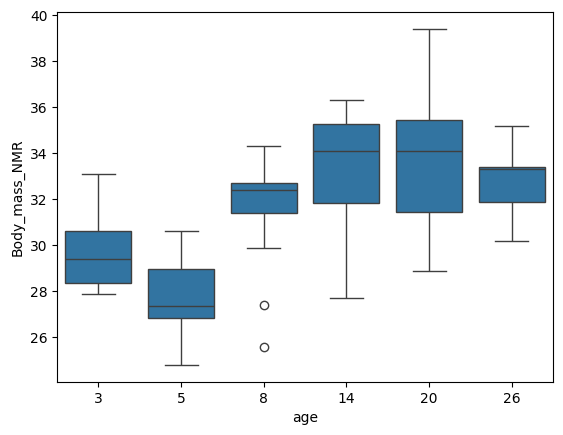

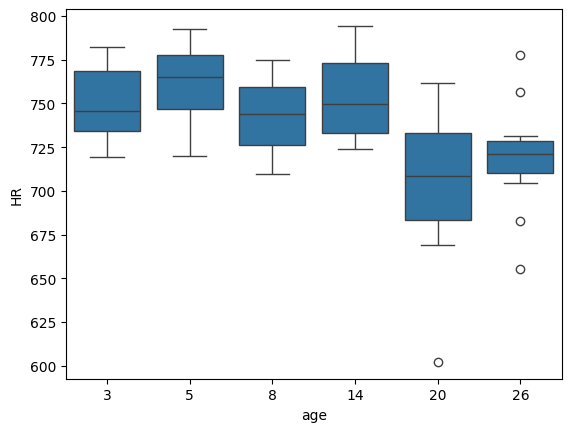

In [5]:
for vname in ["Body_mass_NMR", "HR"]:
  _, da = get_data("Figure2_phenotypes", vname)
  c = da.groupby("age").count().sort_index()
  print(c)
  plt.figure()
  sns.boxplot(da, x="age", y=vname)

In their paper, the authors claim that 59% of phenotypes have a [statistically significant](https://en.wikipedia.org/wiki/Statistical_significance) association with age.  The underlying analysis uses a nonparametric one-way ANOVA procedure ([Kruskall-Wallis](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test)) for (semi) quantitative phenotypes, and [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) for binary phenotypes.  Below we do a simplified version of this analysis, using the Kruskall-Wallis ANOVA procedure for all phenotypes.  The results are quite similar to those reported in the publication.

In [6]:
n0, n1 = 0, 0
for vname in md["Figure2_phenotypes"].keys():
  vname1, da = get_data("Figure2_phenotypes", vname)
  ga = da.groupby("age").groups
  dx = [da[vname1][g].values for g in ga.values()]
  kr = stats.kruskal(*dx)
  n0 += 1
  n1 += kr.pvalue < 0.05
(n0, n1, n1/n0)

(186, 107, 0.5752688172043011)

Now we turn to diet, which is one of the interventional components of the study.  Mice were on either a calorie-restricted or regular diet.  In these experiments, there were two age groups denoted "young" and "old".  We can use [regression](https://en.wikipedia.org/wiki/Regression_analysis) and [analysis of variance](https://en.wikipedia.org/wiki/Analysis_of_variance) to consider the combined association of age and diet type in relation to each phenotype.  Here we use [ordinary least squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) to fit the models since we want effect estimates and not only significance levels.  We fit a "saturated" model for each phenotype, which has an intercept, main effects for age and diet, and an [interaction](https://en.wikipedia.org/wiki/Interaction_(statistics)) between age and diet.  

In interpreting the results of the analysis, we consider the evidence for additive and non-additive associations between the intervention variable (diet)and the outcome phenotype.  Age is either a [nuisance variable](https://en.wikipedia.org/wiki/Nuisance_variable) or a [moderator](https://en.wikipedia.org/wiki/Moderation_(statistics)) (also known as a _modifier_).  

Since age and diet happen to both be binary here, this is a _2x2 layout_.  The additive model can be parameterized in three degrees of freedom and the non-additive model has four degrees of freedom.  We focus on two [Wald tests](https://en.wikipedia.org/wiki/Wald_test) - one testing for non-additivity and one testing for an additive contribution of diet.  We have minimal interest in the main effect of age so do not formally test that effect below.

There are over 200 phenotypes so we first calculate all of the relevant statistics and store them in a dataframe.

In [7]:
anovas, models, vnames, prev = {}, {}, [], []
for vname in md["Figure5_phenotypes"].keys():
    vname1, da = get_data("Figure5_phenotypes", vname, convert_age=False, standardize_vname=True)
    mm = sm.OLS.from_formula("%s ~ age * diet" % vname1, da)
    rr = mm.fit()
    mx = rr.model.exog
    _,s,_ = np.linalg.svd(mx,0)
    if s[0]/s[-1] > 100000:
        print("Skipping %s" % vname)
        continue
    aa = anova_lm(rr)
    anovas[vname1] = aa
    models[vname1] = rr
    vnames.append(vname1)
    prev.append([(da["age"] == "young").mean(), (da["diet"]=="restricted").mean()])

The next cell organizes all of the regression findings into a dataframe.  This dataframe has one row for each phenotype.

In [8]:
zscores = [models[v].params / models[v].bse for v in vnames]
zscores[0]
young_main = [models[v].params["age[T.young]"] for v in vnames]
young_main_z = [z["age[T.young]"] for z in zscores]
young_main_se = [models[v].bse["age[T.young]"] for v in vnames]
restricted_main = [models[v].params["diet[T.restricted]"] for v in vnames]
restricted_main_z = [z["diet[T.restricted]"] for z in zscores]
restricted_main_se = [models[v].bse["diet[T.restricted]"] for v in vnames]
interaction = [models[v].params["age[T.young]:diet[T.restricted]"] for v in vnames]
interaction_z = [z["age[T.young]:diet[T.restricted]"] for z in zscores]
interaction_se = [models[v].bse["age[T.young]:diet[T.restricted]"] for v in vnames]
prev = np.asarray(prev)

effects = pd.DataFrame({"Variable": vnames,
                        "young_main": young_main, "young_main_z": young_main_z,
                        "young_main_se": young_main_se,
                        "restricted_main": restricted_main, "restricted_main_z": restricted_main_z,
                        "restricted_main_se": restricted_main_se,
                        "interaction": interaction, "interaction_z": interaction_z,
                        "interaction_se": interaction_se,
                        "age_sd": np.sqrt(prev[:, 0] * (1 - prev[:, 0])),
                        "diet_sd": np.sqrt(prev[:, 1] * (1 - prev[:, 1]))})

# Standardized effects
effects["young_main_s"] = effects["young_main"] * effects["age_sd"]
effects["restricted_main_s"] = effects["restricted_main"] * effects["diet_sd"]
effects["restricted_main_s_se"] = effects["restricted_main_se"] * effects["diet_sd"]
effects["interaction_s"] = effects["interaction"] * effects["age_sd"] * effects["diet_sd"]
effects["interaction_s_se"] = effects["interaction_se"] * effects["age_sd"] * effects["diet_sd"]

In [9]:
effects

,Variable,young_main,young_main_z,young_main_se,restricted_main,restricted_main_z,restricted_main_se,interaction,interaction_z,interaction_se,age_sd,diet_sd,young_main_s,restricted_main_s,restricted_main_s_se,interaction_s,interaction_s_se
0,Heart_rate_Echo,-0.126126,-0.285067,0.442443,0.330320,0.765019,0.431780,0.223323,0.351829,0.634748,0.498660,0.499851,-0.062894,0.165111,0.215826,0.055664,0.158215
1,Food_intake_1,1.158684,3.684504,0.314475,-0.041459,-0.131835,0.314475,-0.506879,-1.139734,0.444735,0.500000,0.500000,0.579342,-0.020729,0.157237,-0.126720,0.111184
2,NEFA_fasting,0.854887,2.739568,0.312052,-0.074717,-0.263806,0.283229,-0.815077,-1.855469,0.439284,0.492822,0.499958,0.421308,-0.037356,0.141602,-0.200827,0.108235
3,QT_dispersion,0.703342,1.637635,0.429487,0.397965,0.949489,0.419136,-0.262964,-0.426778,0.616160,0.498660,0.499851,0.350728,0.198923,0.209506,-0.065545,0.153581
4,eu_tremor,-0.224633,-0.688737,0.326152,0.224633,0.760345,0.295436,-0.224633,-0.487011,0.461249,0.491880,0.500000,-0.110493,0.112317,0.147718,-0.055246,0.113440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LV_mass_cor,-0.650819,-1.681332,0.387085,-0.607700,-1.608709,0.377756,-0.227712,-0.410049,0.555329,0.498660,0.499851,-0.324537,-0.303760,0.188822,-0.056759,0.138419
153,Non_HDL_chol_fasting,-0.728937,-2.257006,0.322966,-0.344480,-1.175158,0.293135,0.955698,2.102062,0.454648,0.492822,0.499958,-0.359236,-0.172225,0.146555,0.235475,0.112021
154,MPV,-1.297925,-4.686403,0.276956,-0.598300,-2.345238,0.255113,0.405300,1.045402,0.387698,0.495414,0.499817,-0.643010,-0.299041,0.127510,0.100359,0.096000
155,paws_mean,1.048695,3.461218,0.302984,0.495278,1.801020,0.274999,-0.542205,-1.271233,0.426519,0.492822,0.499958,0.516821,0.247618,0.137488,-0.133594,0.105090


The function below creates a dot-plot of the statistically standardized effects for each phenotype, considering one particular term in the model (i.e. one of the two main effects, or the interaction).  These "statistically standardized effects" are point estimates divided by the corresponding standard errors.  

The vertical lines correspond to common decision thresholds for Z-scores.  The dashed lines correspond to a "nominal" threshold corresponding to an unadjusted p-value being less than 0.05. The dotted lines correspond to thesholds corrected for multiple hypothesis testing using the [Bonferonni method](https://en.wikipedia.org/wiki/Bonferroni_correction), which controls the family-wise error rate.

In [10]:
def gen_anova_z_plot(term):
  dof = models[vnames[0]].df_resid
  plt.figure().set_figheight(30)
  sns.stripplot(data=effects.sort_values(term), y="Variable", x=term)
  plt.axvline(x=0, color="grey")
  t = stats.distributions.t(df=dof).ppf(1 - 0.025/effects.shape[0])
  plt.axvline(x=-t, color="grey", ls="dotted")
  plt.axvline(x=t, color="grey", ls="dotted")
  plt.axvline(x=-2, color="grey", ls="dashed")
  plt.axvline(x=2, color="grey", ls="dashed")
  plt.yticks(fontsize=6);

The plot below shows the parameter Z-scores for each phenotype, for the diet main effect.  Since there is an interaction in the model, these effects correspond to the difference between diet groups, fixing age at "old".

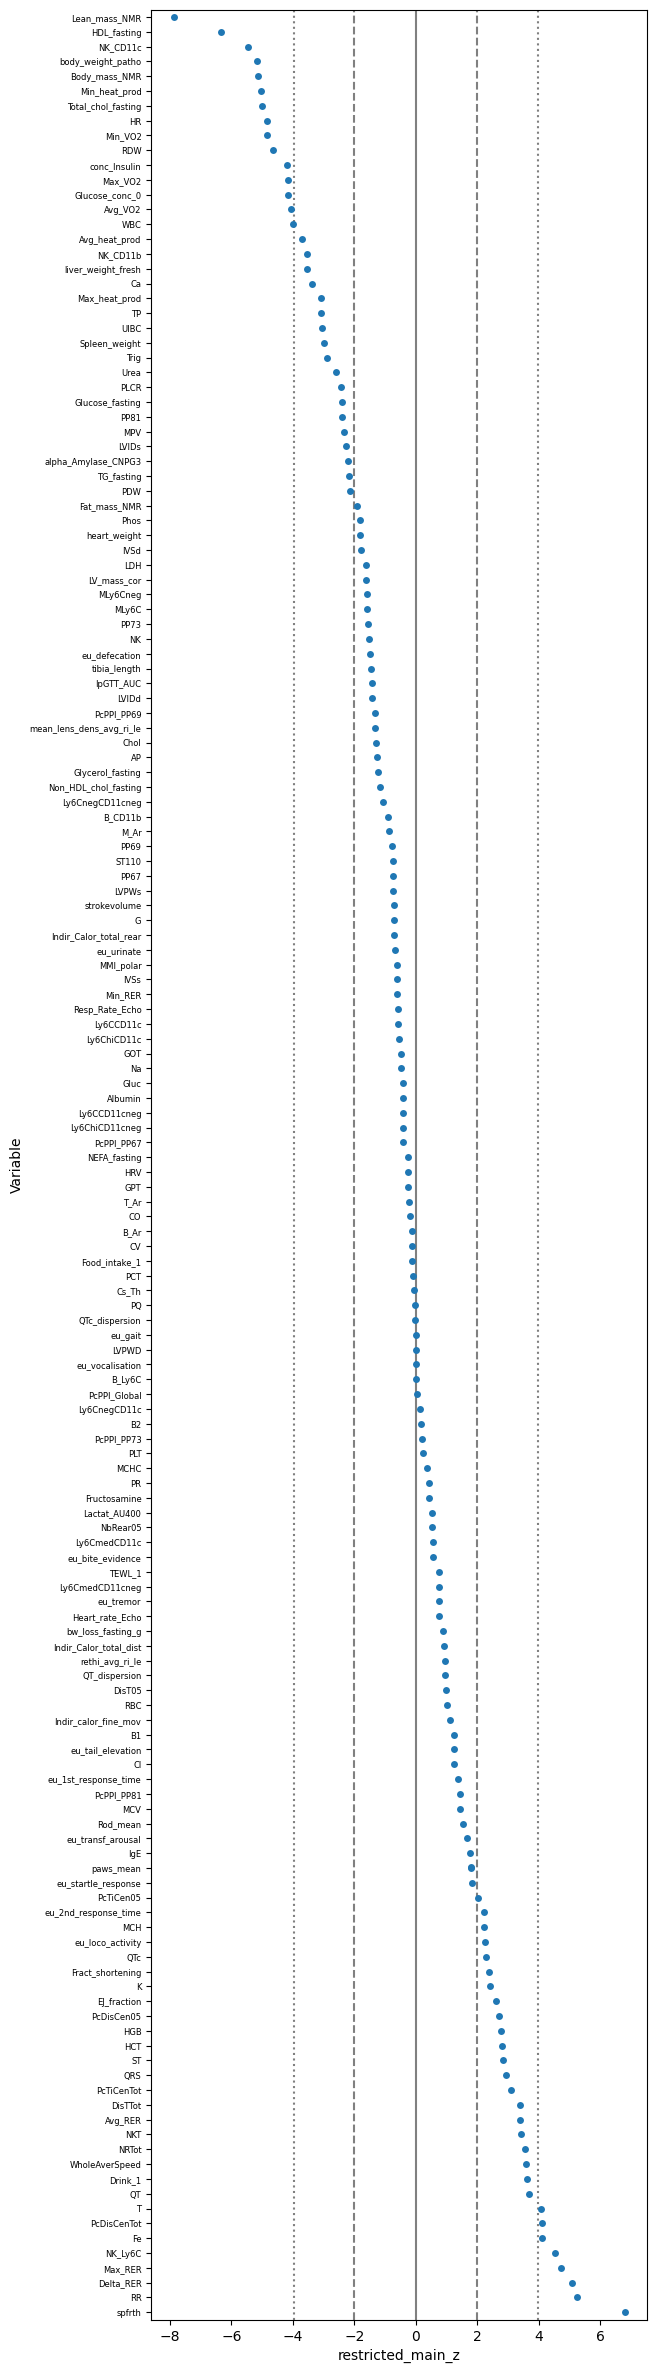

In [11]:
gen_anova_z_plot("restricted_main_z")

The plot below shows the interaction effects for each phenotype.  Note that none of them reach the threshold required for [family-wise](https://en.wikipedia.org/wiki/Family-wise_error_rate) error control.

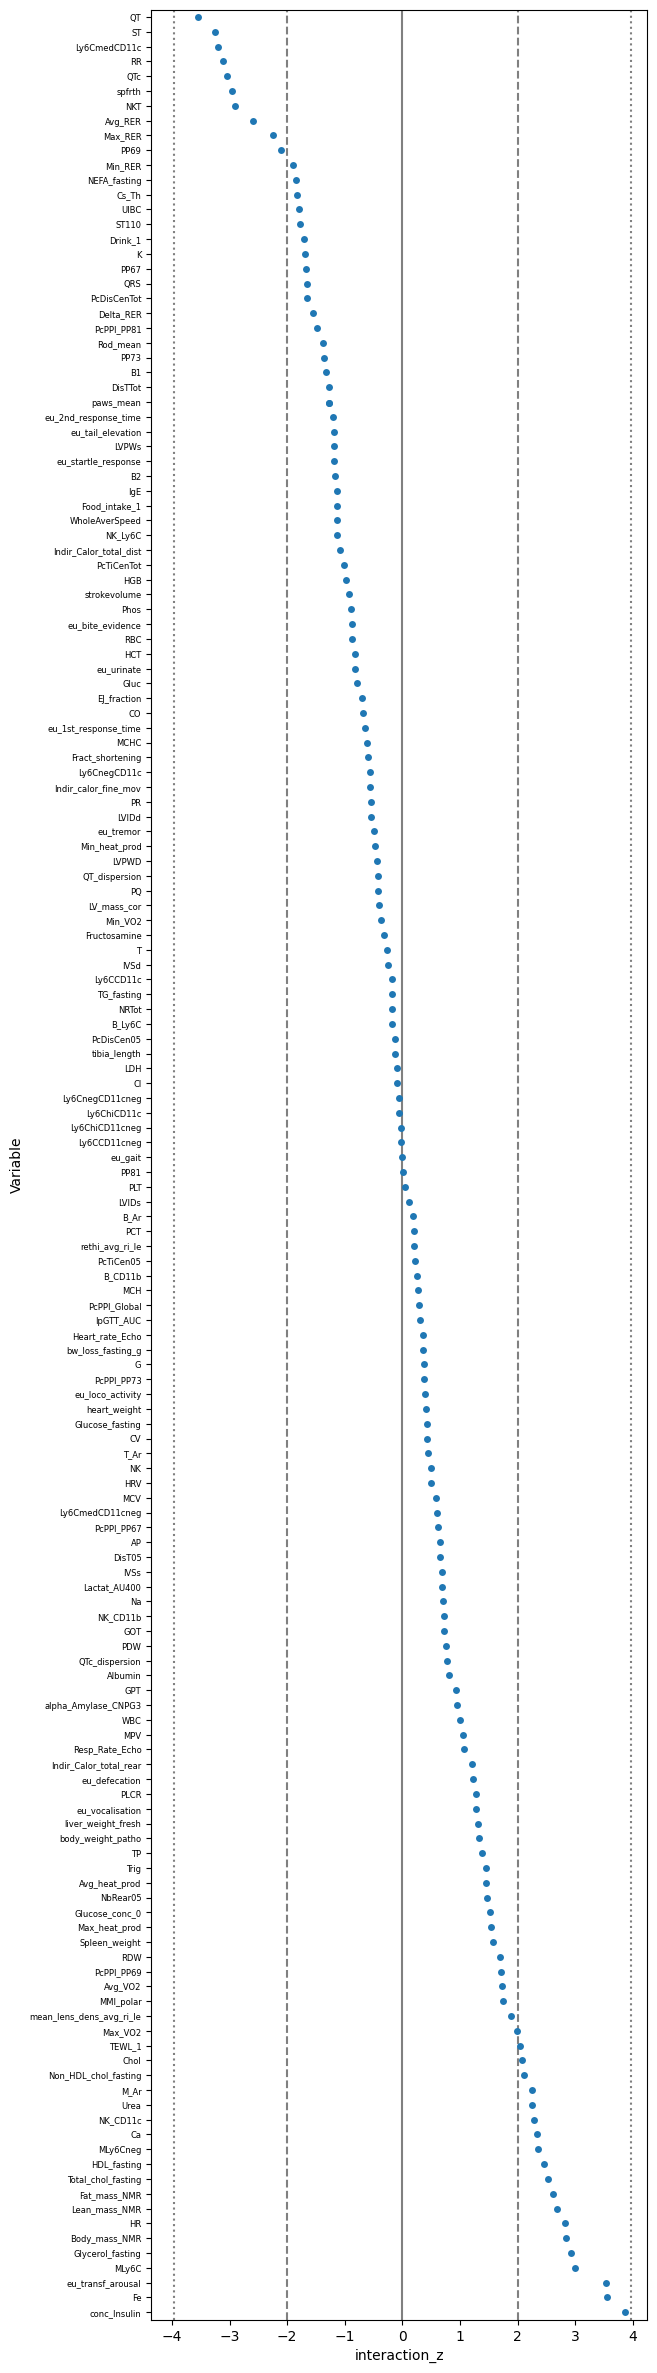

In [12]:
gen_anova_z_plot("interaction_z")

Next we visualize the same effects using a different approach.  A "standardized effect" refers here to the effect of one covariate relative to its standard deviation (above we considered Z-scores which are the effects relative to their [standard error](https://en.wikipedia.org/wiki/Standard_error)). Both Z-scores and standardized effects are dimension-free.  Standardized effects are a measure of the [size of an effect](https://en.wikipedia.org/wiki/Effect_size), not its statistical significance.  In order to convey information about statistical significance in these plots, we also include 95% [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) (adjusted for multiple comparisons) for each standardized effect.

In [13]:
def gen_anova_seffect_plot(term):
  dof = models[vnames[0]].df_resid
  plt.figure().set_figheight(30)
  ee = effects.copy()
  t = stats.distributions.t(df=dof).ppf(1 - 0.025/effects.shape[0])
  ee["lcb"] = ee[term] - t*ee["%s_se" % term]
  ee["ucb"] = ee[term] + t*ee["%s_se" % term]
  ee = ee[["Variable", "lcb", "ucb", term]]
  ee = ee.set_index("Variable").stack().reset_index()
  ee.columns = ["Variable", "hue", term]
  ee["hue"] = ee["hue"].replace({"lcb": "cb", "ucb": "cb"})
  ee = ee.sort_values(term)
  sns.stripplot(data=ee, y="Variable", x=term, hue="hue")
  plt.axvline(x=0, color="grey")
  plt.gca().legend().set_visible(False)

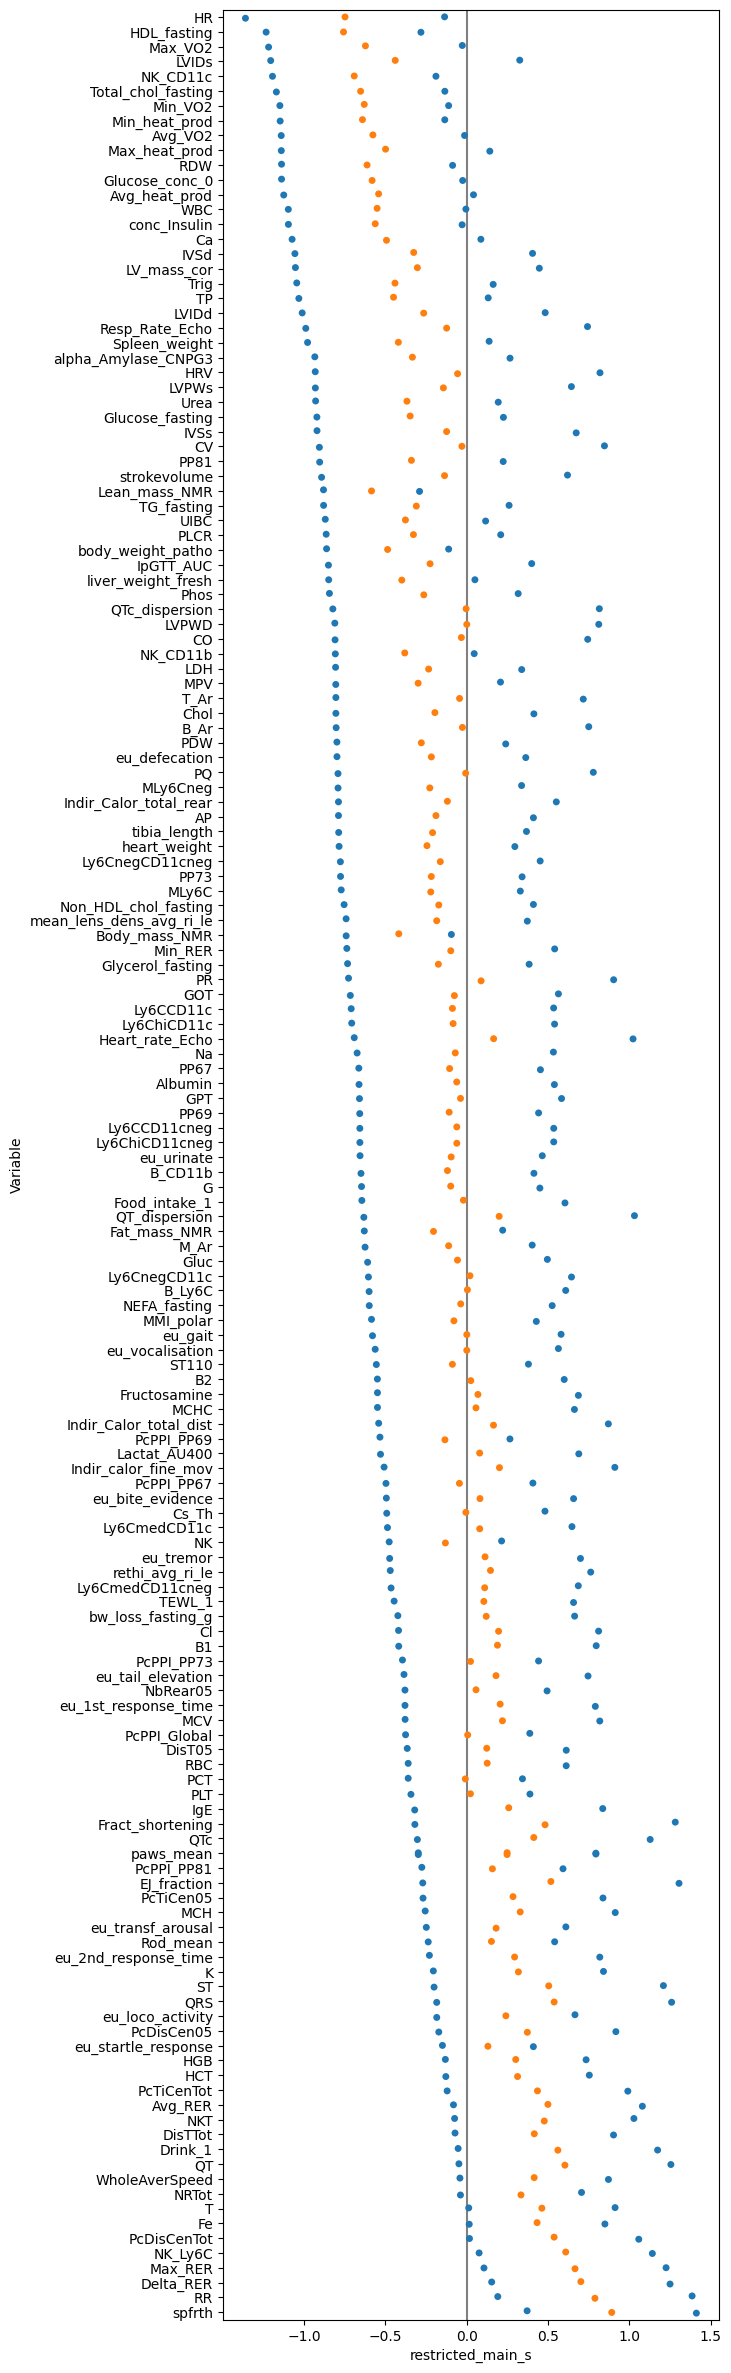

In [14]:
gen_anova_seffect_plot("restricted_main_s")

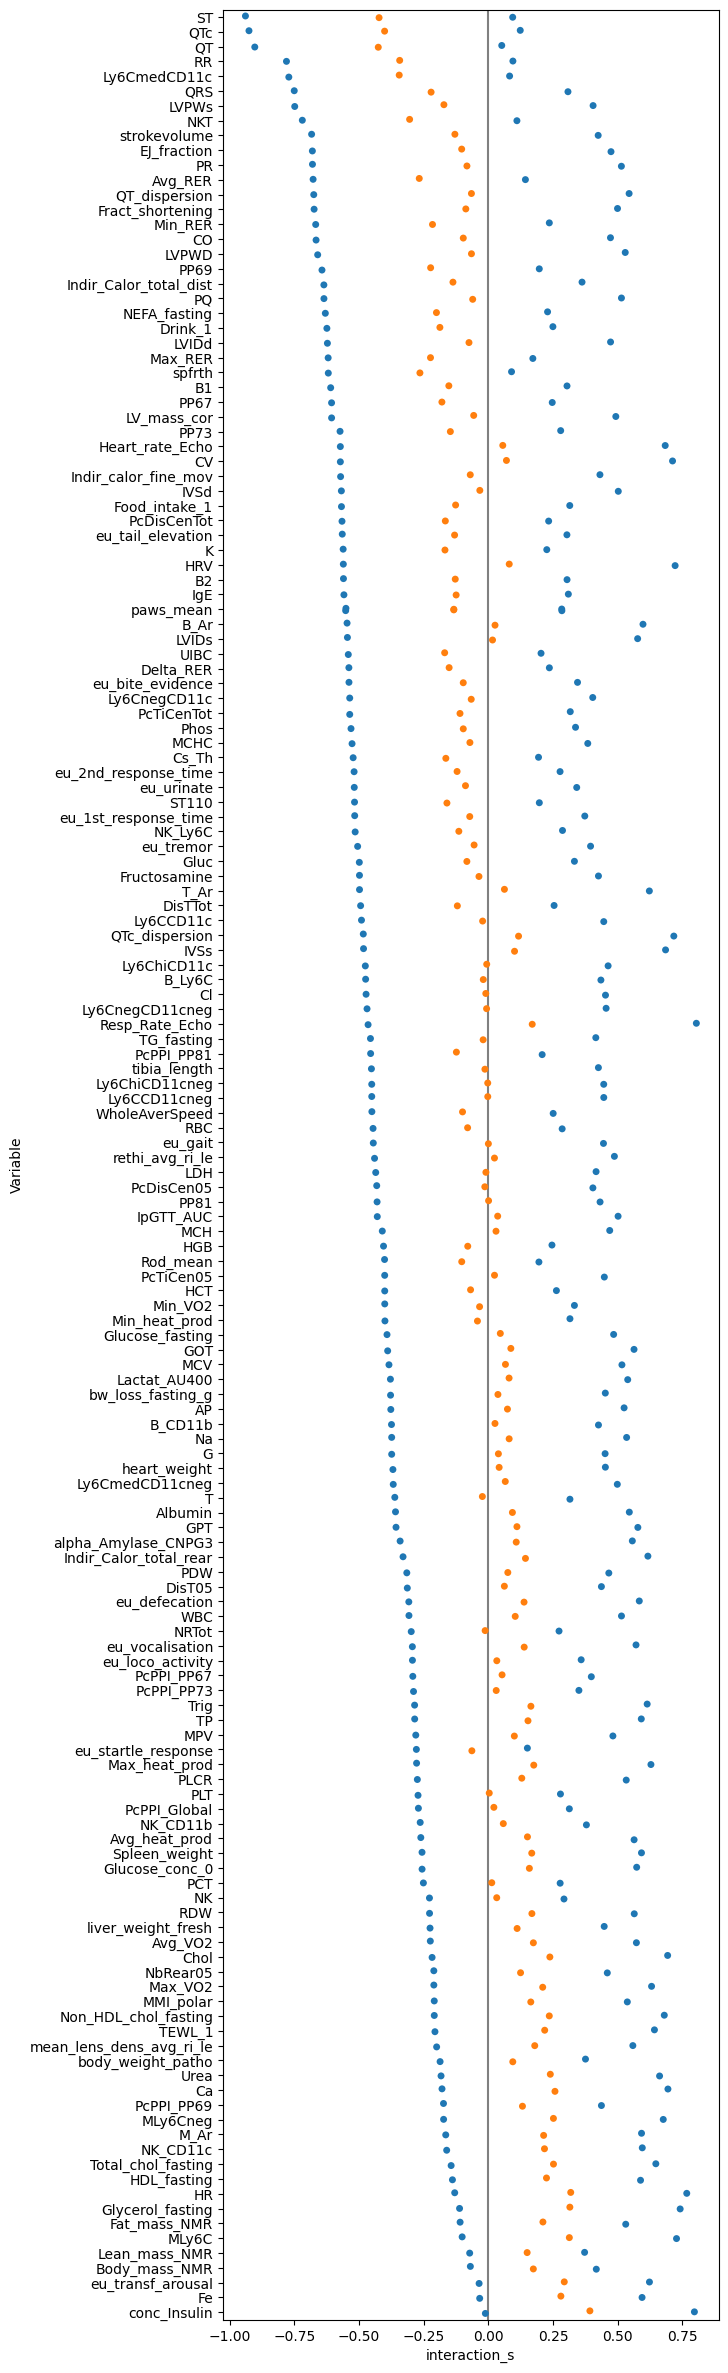

In [15]:
gen_anova_seffect_plot("interaction_s")